<h1>Project description</h1>

<h3>This dataset contains Real Estate listings in the US broken by State and zip code.</h3>
<h5>Features of the dataset:</h5>
<ul>
    <li>status (Housing status - a. ready for sale or b. ready to build)</li>
    <li>bed (# of beds)</li>
    <li>bath (# of bathrooms)
    <li>acre_lot (Property / Land size in acres)</li>
    <li>city (city name)</li>
    <li>state (state name)</li>
    <li>zip_code (postal code of the area)</li>
    <li>house_size (house area/size/living space in square feet)</li>
    <li>prev_sold_date (Previously sold date)</li>
    <li>price (Housing price, it is either the current listing price or recently sold price if the house is sold recently)</li>
</ul>
NB: acre_lot means the total land area, and house_size denotes the living space/building area

<h5>Goals</h5>
<ul>
    <li>Can we predict housing prices based on the features?</li>
    <li>How are housing price and location attributes correlated?</li>
    <li>What is the overall picture of the USA housing prices w.r.t. locations?</li>
    <li>Do house attributes (bedroom, bathroom count) strongly correlate with the price? Are there any hidden patterns?</li>
</ul>



In [49]:
import opendatasets as od
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import plotly.express as px
from functools import partial

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.inspection import PartialDependenceDisplay

import eli5
from eli5.sklearn import PermutationImportance

from catboost import CatBoostRegressor

from skopt.space import Integer, Real
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt import BayesSearchCV
from skopt.plots import plot_convergence

import warnings

warnings.filterwarnings("ignore")

if not os.path.exists("../datasets"):
    os.makedirs("../datasets")

PROJECT_URL = "https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset"
PROJECT_NAME = PROJECT_URL.split("/")[-1]
DATA_PATH = os.path.join("../datasets", PROJECT_NAME)
od.download(PROJECT_URL, "../datasets")
start_time = time.time()

Skipping, found downloaded files in "../datasets/usa-real-estate-dataset" (use force=True to force download)


#### Functions

In [50]:
# Removing outliers
def find_outliers(col):

    Q1, Q3 = col.describe()[["25%", "75%"]]
    IQR = Q3 - Q1
    high = Q3 + IQR * 1.5
    low = Q1 - IQR * 1.5
    is_outliar = col.map(lambda x: x > high or x < low)
    print(f"Found {(is_outliar).sum()} outliers")

    return is_outliar

def cv_calc(model, X, y, cv=5):
    
    t1 = time.time()
    scores = np.sqrt(-cross_val_score(model, X, y, cv=cv, n_jobs=-1, scoring="neg_mean_squared_error"))
    t2 = time.time() - t1
    calc_time = round(t2,2)
    scores = round(np.mean(scores),5)

    print(f"Cross validation Mean squared error: {scores}\nTime: {calc_time}s")

    return calc_time, scores

def custom_fillnas(df):
    df_imp = df.dropna(subset=["city", "state", "price"])

    # If the city has values
    df_imp.loc[:, "bed"] = df_imp["bed"].fillna(df_imp.groupby("city").bed.transform("median").transform("round"))
    df_imp.loc[:, "bath"] = df_imp["bath"].fillna(df_imp.groupby("city").bath.transform("median").transform("round"))
    df_imp.loc[:, "acre_lot"] = df_imp["acre_lot"].fillna(df_imp.groupby("city").acre_lot.transform("median"))
    df_imp.loc[:, "house_size"] = df_imp["house_size"].fillna(df_imp.groupby("city").house_size.transform("median"))
    # If the city is missing values
    df_imp.loc[:, "bed"] = df_imp["bed"].fillna(round(df_imp.bed.median()))
    df_imp.loc[:, "bath"] = df_imp["bath"].fillna(round(df_imp.bath.median()))
    df_imp.loc[:, "acre_lot"] = df_imp["acre_lot"].fillna(df_imp.acre_lot.median())
    df_imp.loc[:, "house_size"] = df_imp["house_size"].fillna(df_imp.house_size.median())

    df_imp = df_imp.dropna()
    X_imp = df_imp.drop(columns=["price"])
    y_imp = df_imp["price"].copy()

    return X_imp, y_imp

### EDA

In [51]:
df = pd.read_csv(os.path.join(DATA_PATH, os.listdir(DATA_PATH)[0]))
df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0


In [52]:
print(f"There are {df.duplicated().sum()} duplicate rows")
print(f"Shape before: {df.shape}")
df = df.drop_duplicates()
print(f"Shape after: {df.shape}")

There are 85364 duplicate rows
Shape before: (100000, 10)
Shape after: (14636, 10)


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14636 entries, 0 to 97288
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   status          14636 non-null  object 
 1   bed             11288 non-null  float64
 2   bath            11289 non-null  float64
 3   acre_lot        12792 non-null  float64
 4   city            14620 non-null  object 
 5   state           14636 non-null  object 
 6   zip_code        14608 non-null  float64
 7   house_size      11290 non-null  float64
 8   prev_sold_date  5296 non-null   object 
 9   price           14636 non-null  float64
dtypes: float64(6), object(4)
memory usage: 1.2+ MB


In [54]:
df.describe().style.format("{:.2f}")

,bed,bath,acre_lot,zip_code,house_size,price
count,11288.00,11289.00,12792.00,14608.00,11290.00,14636.00
mean,3.64,2.57,32.31,3479.00,2401.62,538439.36
std,2.00,1.63,1535.86,3219.51,13823.22,1249873.48
min,1.00,1.00,0.00,601.00,100.00,445.00
25%,3.00,2.00,0.19,1035.00,1228.25,165000.00
50%,3.00,2.00,0.50,2816.00,1759.00,299900.00
75%,4.00,3.00,1.90,6062.00,2693.50,499900.00
max,86.00,56.00,100000.00,99999.00,1450112.00,60000000.00


In [55]:
df.describe(include='O').T

,count,unique,top,freq
status,14636,2,for_sale,14609
city,14620,525,San Juan,406
state,14636,12,Connecticut,3836
prev_sold_date,5296,3604,2021-10-18,7


In [56]:
round(df.isnull().sum()/df.shape[0],2)

status            0.00
bed               0.23
bath              0.23
acre_lot          0.13
city              0.00
state             0.00
zip_code          0.00
house_size        0.23
prev_sold_date    0.64
price             0.00
dtype: float64

<ul>
    <li>Dropping <b>status</b> since more than 99% of the values are the same</li>
    <li>Dropping <b>prev_sold_date</b> because the column has 63% missing values</li>
    <li>Dropping <b>zip_code</b> as it's hard to convey it into useful information</li>
</ul>

In [57]:
# Status seems irrelevant , prev_sold_date 71% missing values
df.drop(columns=["status", "prev_sold_date", "zip_code"], inplace=True)

From the output of <b>.describe()</b> we see that we have outliars.
<p>I will remove them using the rule anything outside the interval <b>[Q1 - interquartile range * 1.5,  Q3 + interquartile range * 1.5]</b> is an outliar.</p> 
Running this in an iterative manner for every column gives better performance compared to precalculating them for each column before removing the outliars.

In [58]:
print(df.shape)
for c in ["bed", "bath", "acre_lot", "house_size", "price"]:
    print(f"checking {c}")
    
    df = df.loc[~find_outliers(df[c]), :]
print(df.shape)

(14636, 7)
checking bed
Found 1534 outliers
checking bath
Found 427 outliers
checking acre_lot
Found 1642 outliers
checking house_size
Found 360 outliers
checking price
Found 536 outliers
(10137, 7)


In [59]:
print(df.state.value_counts())

state
Connecticut       2947
Massachusetts     2501
Puerto Rico       1806
Rhode Island      1486
Virgin Islands     510
New Hampshire      397
New York           341
Vermont            145
New Jersey           1
South Carolina       1
Tennessee            1
Virginia             1
Name: count, dtype: int64


Dropping <b>states</b> that have low sample size.

In [60]:
print(df.shape)
df = df.loc[~df.state.isin(["South Carolina", "Tennessee", "Virginia", "New Jersey"]), :]
print(df.shape)

(10137, 7)
(10133, 7)


In [61]:
df.city.value_counts()

city
Christiansted      236
San Juan           215
Warwick            202
Providence         199
Cranston           152
                  ... 
Scotland             1
Chatham Village      1
East Chatham         1
Peru                 1
Newfane              1
Name: count, Length: 493, dtype: int64

Dropping cities with low sample size. Multiple values were tried, 30 looked like the sweet spot.

In [62]:
# Drop cities with low sample size
tmp = df.city.value_counts().reset_index()
city_count_map = dict(zip(tmp["city"], tmp["count"]))
df = df.assign(city_count = lambda x: x["city"].map(city_count_map))

print(df.shape)
df = df.loc[df["city_count"] >= 80, :]
print(df.shape)
df.drop(columns=["city_count"], inplace=True)

(10133, 8)
(2867, 8)


<h3>Plots</h3>

<b>Plotting average prices for cities and states</b>

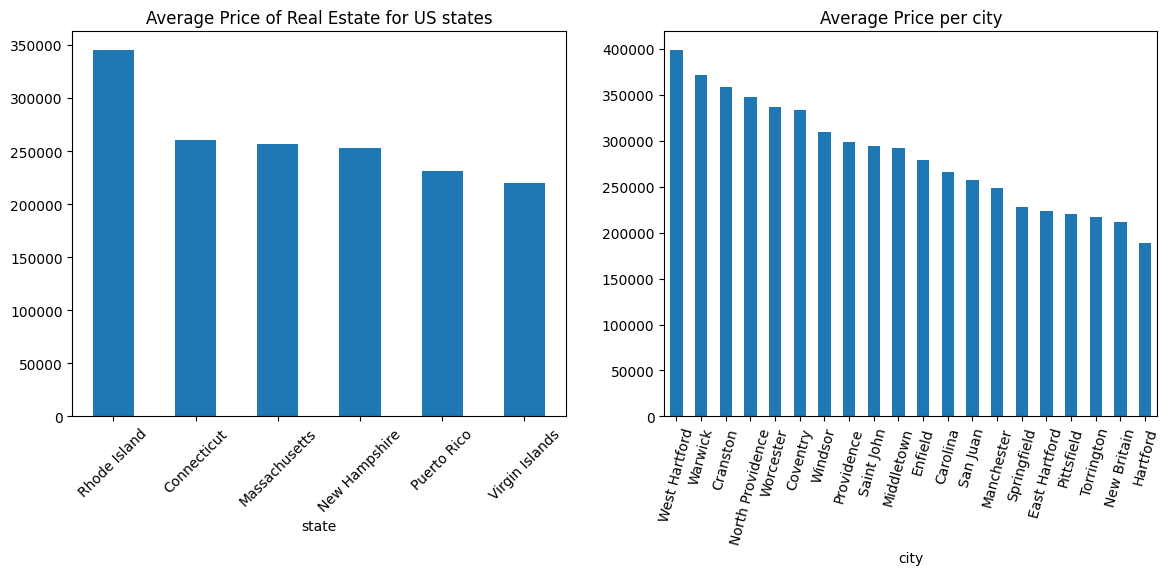

In [63]:
plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
df.groupby('state').price.mean().sort_values(ascending=False).plot.bar(ax=ax1)
plt.title('Average Price of Real Estate for US states')
plt.xticks(rotation=45)
ax2 = plt.subplot(1,2,2)
df.groupby('city').price.mean().sort_values(ascending=False).head(20).plot.bar(ax=ax2)
ax2.xaxis.set_tick_params(labelsize=10)
plt.title('Average Price per city')
plt.xticks(rotation=75)
plt.show()

<b>Scatter plots for prices over acre_lot and house_size</b>

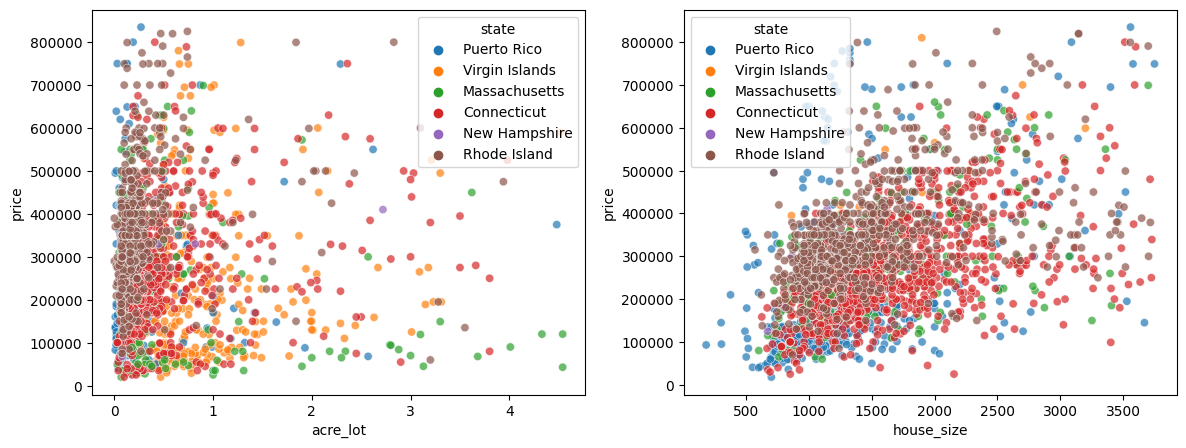

In [64]:
# Scatter plots
plt.figure(figsize=(14,5))
ax1 = plt.subplot(1,2,1)
sns.scatterplot(df, x="acre_lot", y="price", hue="state", alpha=0.7, ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.scatterplot(df, x="house_size", y="price", hue="state", alpha=0.7, ax=ax2)
plt.show()

<b>Heatmap of the features and the price column distribution</b>

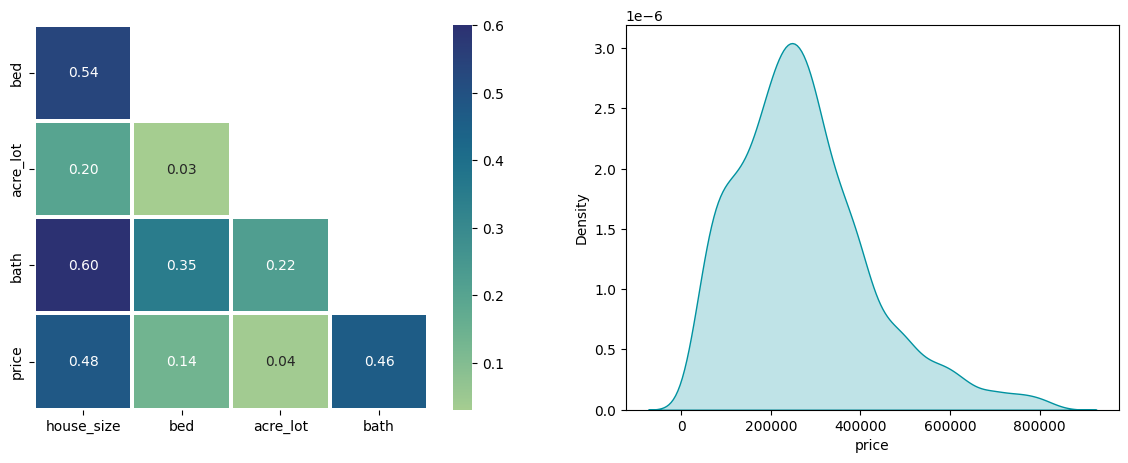

In [65]:
# Heat map with price distribution
plt.figure(figsize=(14,5))
corr_mat = df[["house_size", "bed", "acre_lot", "bath", "price"]].corr()
mask = np.triu(np.ones_like(corr_mat)).astype(bool)
mask = mask[1:, :-1]
corr_mat = corr_mat.iloc[1:,:-1]
ax1 = plt.subplot(1,2,1)
sns.heatmap(corr_mat, annot=True, linewidth=1.5, fmt=".2f", cmap="crest", mask=mask, ax=ax1)
ax2 = plt.subplot(1,2,2)
sns.kdeplot(df["price"], fill=True, color="#0092A0", ax=ax2)
plt.show()

<b>Boxplots over price for bed, bath and state</b>

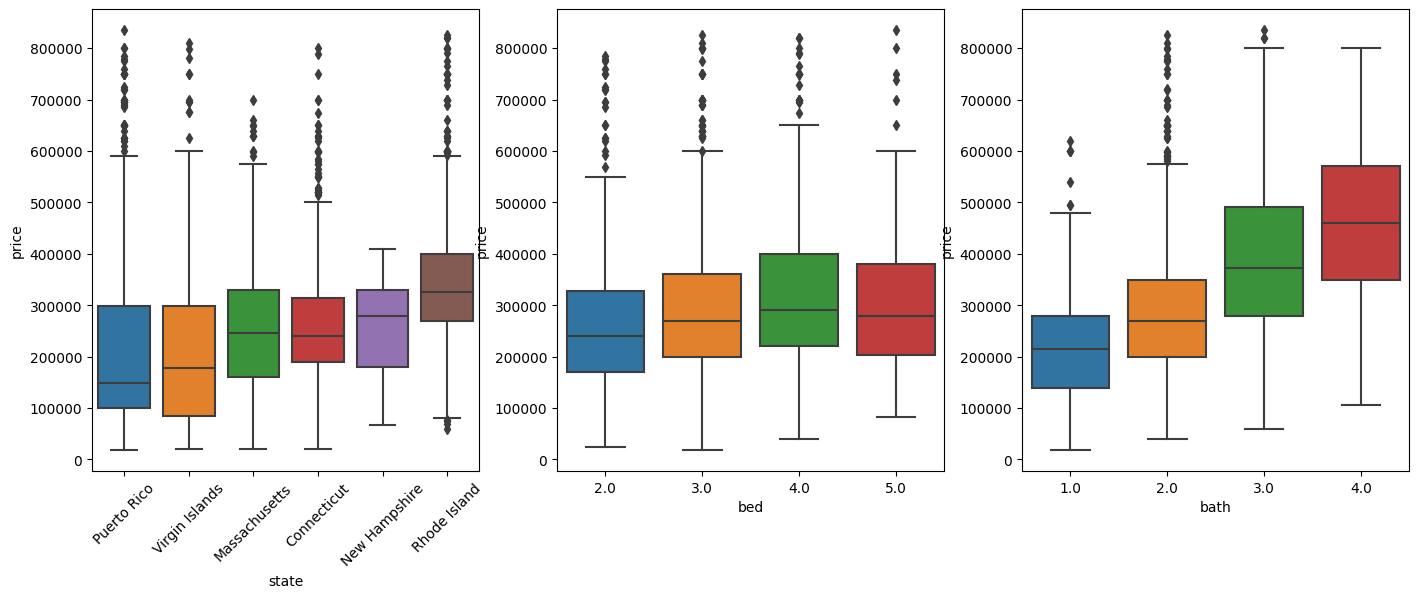

In [66]:
# Box plots
plt.figure(figsize=(17,6))
ax1 = plt.subplot(1,3,1)
sns.boxplot(df, x="state", y="price", ax=ax1)
plt.xticks(rotation=45)
ax2 = plt.subplot(1,3,2)
sns.boxplot(df, x="bed", y="price", ax=ax2)
ax3 = plt.subplot(1,3,3)
sns.boxplot(df, x="bath", y="price", ax=ax3)
plt.show()

<u><b>Observations on plots:</b></u><br>
Looks like number of bathrooms and house size have a linear correlation with the price which is an expected result and should have strong predictive power.<br>

Also:
<ul>
    <li>Acre_lot - Price scatter plot doesn't reveal any obvious pattern.</li> 
    <li>There is no obvious pattern for acre_lot.</li> 
    <li>States are having different price distributions.</li>
    <li>Price distributions of beds look different between the groups 2,3 and 4,5.</li>
    <li>Price distributions of baths are very different, which is an indication for a strong predictor.</li> 
</ul> 

## Models

In [67]:
metrics = {}


df_train, df_test = train_test_split(df, test_size=0.2, random_state=47, stratify=df["city"].tolist())

### Models with dropping all NaN values

In [68]:
# Drop rows that have at least one null value
print("Dataframe size before dropna:", df.shape)
df_train_dropna_all = df.dropna()
print("Dataframe size after dropna:", df_train_dropna_all.shape)

Dataframe size before dropna: (2867, 7)
Dataframe size after dropna: (1932, 7)


In [69]:
df_train_dropna_all.shape

(1932, 7)

In [70]:
# Split features and labels
X_dropna_all = df_train_dropna_all.drop(columns=["price"])
y_dropna_all = df_train_dropna_all["price"].copy()

<h5>Models with only with numerical columns</h5>

In [71]:
X_dropna_all_num = X_dropna_all.select_dtypes(exclude=["object"])

RandomForest

In [72]:
forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_dropna_all_num, y_dropna_all)
metrics["forest_dropna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 119458.62795
Time: 0.88s


CatBoost

In [73]:
# Catboost
cat = CatBoostRegressor(random_state=47, verbose=0)
calc_time, score = cv_calc(cat, X_dropna_all_num, y_dropna_all)
metrics["catboost_dropna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 115822.74371
Time: 2.24s


<h5>Models with adding categorical columns</h5>

RandomForest

In [74]:
X_dropna_all_oh = pd.get_dummies(X_dropna_all)

forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_dropna_all_oh, y_dropna_all)
metrics["forest_dropna_oh"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 91335.82214
Time: 0.61s


CatBoost

In [75]:
cat = CatBoostRegressor(random_state=47, verbose=0)
calc_time, score = cv_calc(cat, X_dropna_all_oh, y_dropna_all)
metrics["catboost_dropna_oh"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 84440.73283
Time: 2.62s


<h3>Fillnas for missing values</h3>

In [76]:
# fillnas
X_imp, y_imp = custom_fillnas(df_train)

<h5>Models with only numerical columns</h5>

Random forest

In [77]:
X_imp_num = X_imp.select_dtypes(exclude=["object"])

In [78]:
forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_imp_num, y_imp)
metrics["forest_fillna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 127738.81703
Time: 0.27s


CatBoost

In [79]:
catboost_reg = CatBoostRegressor(verbose=0, random_state=47)
calc_time, score = cv_calc(catboost_reg, X_imp_num, y_imp)
metrics["catboost_fillna_num"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 123612.69169
Time: 2.53s


<h4>Models with Fillnas and one hot for categorical</h4>

In [80]:
X_imp_oh = pd.get_dummies(X_imp)

RandomForest

In [81]:
forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_imp_oh, y_imp)
metrics["forest_fillna_oh"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 108150.05901
Time: 0.34s


CatBoost

In [82]:
catboost_reg = CatBoostRegressor(verbose=0, random_state=47)
calc_time, score = cv_calc(catboost_reg, X_imp_oh, y_imp)
metrics["catboost_fillna_oh"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 104571.74466
Time: 2.64s


<b>Models with Feature scaling</b>

In [83]:
scaler = StandardScaler()
X_dropna_num = X_imp.select_dtypes(exclude=["object"])
X_dropna_obj = X_imp.select_dtypes(exclude=["float64"])
X_temp = scaler.fit_transform(X_dropna_num)
X_dropna_num = pd.DataFrame(X_temp, columns=X_dropna_num.columns.tolist())
X_dropna_scaled = X_imp_num.join(X_dropna_obj) 
X_dropna_scaled_oh = pd.get_dummies(X_dropna_scaled)

RandomForest

In [84]:
forest_reg = RandomForestRegressor(n_jobs=-1, random_state=47)
calc_time, score = cv_calc(forest_reg, X_dropna_scaled_oh, y_imp)
metrics["forest_dropna_scaled"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 108150.05901
Time: 0.33s


CatBoost

In [85]:
catboost_reg = CatBoostRegressor(verbose=0, random_state=47)
calc_time, score = cv_calc(catboost_reg, X_dropna_scaled_oh, y_imp)
metrics["catboost_dropna_scaled"] = {"time":calc_time, "score": score}

Cross validation Mean squared error: 104571.74466
Time: 2.93s


<h4>Models with Feature Engineering</h4>

Adding clusters

In [86]:
def add_clusters(X, y):
    X_cp = X.copy()
    km = KMeans(n_clusters=4, random_state=47)
    tmp = X_cp.join(y).loc[: , ["bed", "bath", "house_size"]]
    tmp["cluster"] = km.fit_predict(tmp)
    tmp.loc[:, "cluster"] = tmp["cluster"].astype("category")
    X_cp["cluster"] = tmp["cluster"]

    return X_cp

In [87]:
X_dropna_cls = add_clusters(X_dropna_all, y_dropna_all)
X_dropna_cls_oh = pd.get_dummies(X_dropna_cls)

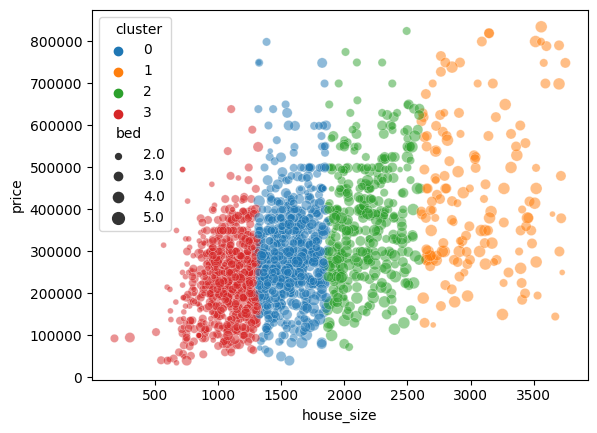

In [88]:
sns.scatterplot(x="house_size", y="price", hue="cluster", alpha=0.5, size="bed", data=X_dropna_cls.join(y_dropna_all))
plt.show()

In [89]:
catboost_reg = CatBoostRegressor(verbose=0, random_state=47)
calc_time, score = cv_calc(catboost_reg, X_dropna_cls_oh, y_dropna_all)
metrics["cat_dropna_cluster_oh"] = {"time": calc_time, "score": score}

Cross validation Mean squared error: 84842.70692
Time: 2.78s


Polynomial Features

In [90]:
num_cols = list(X_dropna_all.select_dtypes(exclude=["object"]))
cat_cols = list(X_dropna_all.select_dtypes(exclude=["float64"]))

poly_transformer = ColumnTransformer([
    ("num", PolynomialFeatures(degree=2), num_cols),
    ("cat", OneHotEncoder(), cat_cols)
])

X_dropna_poly_oh = poly_transformer.fit_transform(X_dropna_all)

In [91]:
catboost_reg = CatBoostRegressor(verbose=0, random_state=47)
calc_time, score = cv_calc(catboost_reg, X_dropna_poly_oh, y_dropna_all)
metrics["cat_dropna_polynom_oh"] = {"time": calc_time, "score": score}

Cross validation Mean squared error: 85204.25007
Time: 3.93s


Custom features

In [92]:
X_dropna_newfeat = X_dropna_all_oh.copy()
X_dropna_newfeat["house_size_over_bed"] = X_dropna_newfeat["house_size"]/X_dropna_newfeat["bed"]
X_dropna_newfeat["house_size_over_bath"] = X_dropna_newfeat["house_size"]/X_dropna_newfeat["bath"]
X_dropna_newfeat["bed_plus_bath"] = X_dropna_newfeat["bed"] + X_dropna_newfeat["bath"]

In [93]:
catboost_reg = CatBoostRegressor(verbose=0, random_state=47)
calc_time, score = cv_calc(catboost_reg, X_dropna_newfeat, y_dropna_all)
metrics["cat_dropna_customfeature_oh"] = {"time": calc_time, "score": score}

Cross validation Mean squared error: 85556.80494
Time: 3.04s


Showing them all together from best performer to worst

In [94]:
pd.DataFrame(metrics).T.sort_values(by="score", ascending=True)

,time,score
catboost_dropna_oh,2.62,84440.73283
cat_dropna_cluster_oh,2.78,84842.70692
cat_dropna_polynom_oh,3.93,85204.25007
cat_dropna_customfeature_oh,3.04,85556.80494
forest_dropna_oh,0.61,91335.82214
catboost_fillna_oh,2.64,104571.74466
catboost_dropna_scaled,2.93,104571.74466
forest_fillna_oh,0.34,108150.05901
forest_dropna_scaled,0.33,108150.05901
catboost_dropna_num,2.24,115822.74371


<b>Observations</b>
<ul>
    <li>Dropping outliars improved performance</li>
    <li>Dropping cities with low sample size improved performance and speed up training</li>
    <li>Adding clusters did not improve performance</li>
    <li>Feature engineering didn't improve the model.</li>
</ul>

### Model optimization with Bayesian Optimization

In [95]:
# Model optimization
search_space = {
    'n_estimators': Integer(900, 2000),
    'max_depth': Integer(1, 12),
    'l2_leaf_reg': Integer(1, 100, "log-uniform"),
    'random_strength': Real(1e-9, 10, 'log-uniform'),
    'bagging_temperature': Real(0.0, 1.0),
    'learning_rate': Real(0.001, 1, "log-uniform")
    }

scoring = make_scorer(partial(mean_squared_error, squared=False), 
                      greater_is_better=False)

model = CatBoostRegressor(random_state=47, verbose=0)

opt = BayesSearchCV(estimator=model, 
              search_spaces=search_space, 
              cv=5, n_iter=60, 
              # n_points=4, 
              scoring=scoring, 
              optimizer_kwargs={'base_estimator': 'GP'},
              n_jobs=-1, 
              random_state=47)

# Running the optimizer
opt_gain_ctrl = DeltaYStopper(delta=0.0001) # We stop if the gain of the optimization becomes too small
time_limit_ctrl = DeadlineStopper(total_time=60*20) # We impose a time limit (20 minutes)
# perform optimization
t1 = time.time()
opt.fit(X_dropna_all_oh, y_dropna_all, callback=[opt_gain_ctrl, time_limit_ctrl])
opt_time = time.time() - t1
minutes = opt_time//60
seconds = opt_time - minutes*60
# summarizing findings:
print(f"Total time: {minutes} minutes and {seconds:.2f}s")
print(f"Best score: {opt.best_score_}\nBest params:")
for k in search_space:
    print(f"    {k} -> {opt.best_params_[k]}")

Total time: 9.0 minutes and 36.86s
Best score: -82652.48898807759
Best params:
    n_estimators -> 2000
    max_depth -> 7
    l2_leaf_reg -> 13
    random_strength -> 10.0
    bagging_temperature -> 0.0
    learning_rate -> 0.02180246133057657


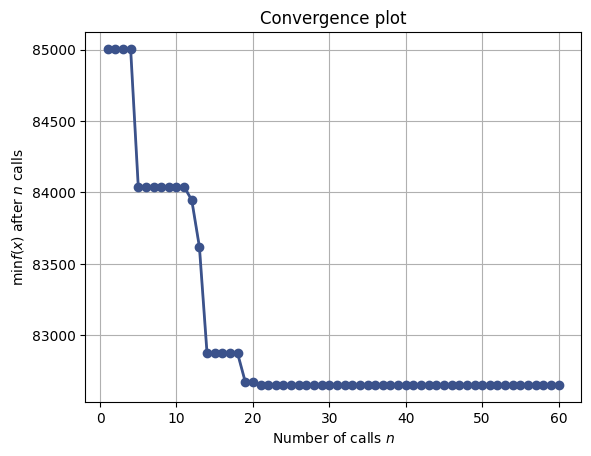

In [96]:
plot_convergence(opt.optimizer_results_)
plt.show()

Testing the best performing dataset on the model parameters returned from the optimization

In [97]:
catboost_opt = CatBoostRegressor(verbose=0, random_state=0)
catboost_opt.set_params(**opt.best_params_)

calc_time, score = cv_calc(catboost_opt, X_dropna_all_oh, y_dropna_all)
metrics["forest_opt_dropna_oh"] = {"time": calc_time, "score": score}

Cross validation Mean squared error: 83410.08882
Time: 5.11s


Plotting all models score with cross validation calculation times

In [98]:
metrics_df = pd.DataFrame(metrics).T.sort_values(by="score", ascending=True)
metrics_df["score"] = round(metrics_df["score"]).astype(int)
metrics_df = metrics_df.reset_index().rename(columns={"index": "model"})

fig = px.scatter(metrics_df, x="time", y="score", color="model", height=500, width=900, title="Model score over training time, lower score and lower time is better")
fig.update_traces(marker=dict(size=8,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.update_layout(titlefont=dict(size=23))
fig.show()

<h3>Model explainability</h3> (work in progress)

In [99]:
# In order to run permutation importance had to drop cities that not show in the test set after dropna

df_test_dropna = df_test.dropna()
df_train_dropna = df_train.dropna()

# Find cities only in train set
cities_to_drop = []
for c in df_train_dropna.city.tolist():
    if not c in df_test_dropna.city.tolist():
        cities_to_drop.append(c)

# Mark them for removal
df_train_dropna["city"] = df_train_dropna["city"].map(lambda x: np.nan if x in cities_to_drop else x)

print("Shape before:", df_train_dropna.shape)
df_train_dropna = df_train_dropna.dropna()
print("Shape after:", df_train_dropna.shape)

# Split features from targets
X_test_dropna, y_test_dropna = (df_test_dropna.drop(columns=["price"]), df_test_dropna["price"].copy())
X_train_dropna, y_train_dropna = (df_train_dropna.drop(columns=["price"]), df_train_dropna["price"].copy())

X_test_dropna_oh = pd.get_dummies(X_test_dropna)
X_train_dropna_oh = pd.get_dummies(X_train_dropna)

Shape before: (1528, 7)
Shape after: (1519, 7)


In [100]:
# Permutation importance
catboost_opt = CatBoostRegressor(verbose=0, random_state=0)
catboost_opt.set_params(**opt.best_params_)
catboost_opt.fit(X_train_dropna_oh, y_train_dropna)

perm = PermutationImportance(catboost_opt, random_state=47).fit(X_test_dropna_oh, y_test_dropna)
eli5.show_weights(perm, feature_names=X_test_dropna_oh.columns.tolist())

Weight,Feature
0.3038 ± 0.0221,house_size
0.1972 ± 0.0446,bath
0.1516 ± 0.0560,acre_lot
0.1425 ± 0.0460,state_Rhode Island
0.0597 ± 0.0165,state_Connecticut
0.0549 ± 0.0088,city_West Hartford
0.0281 ± 0.0174,bed
0.0208 ± 0.0046,city_Worcester
0.0169 ± 0.0073,state_Puerto Rico
0.0131 ± 0.0052,city_Warwick


<Axes: >

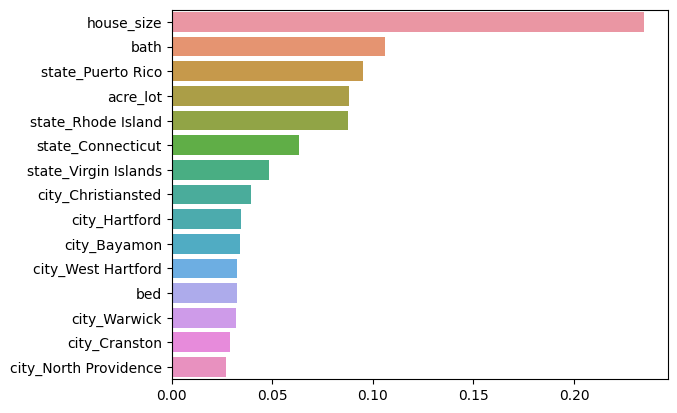

In [108]:
# Mutual information
mi_scores = mutual_info_regression(X_imp_oh, y_imp)
mi_scores = pd.Series(mi_scores, index=X_imp_oh.columns).sort_values(ascending=False).head(15)

sns.barplot(x=mi_scores.values, y=mi_scores.index)

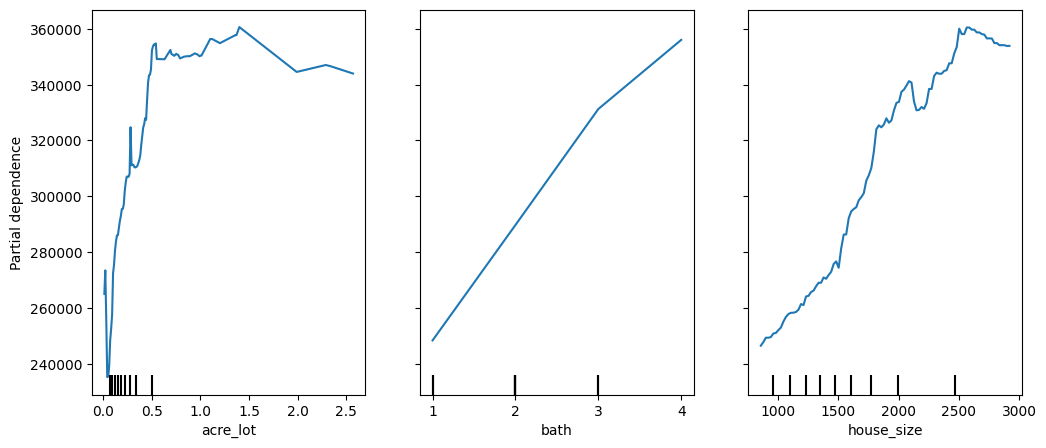

In [102]:
fig, ax = plt.subplots(figsize=(12, 5))
disp2 = PartialDependenceDisplay.from_estimator(catboost_opt, X_test_dropna_oh, ["acre_lot", "bath", "house_size"], ax=ax)

plt.show()

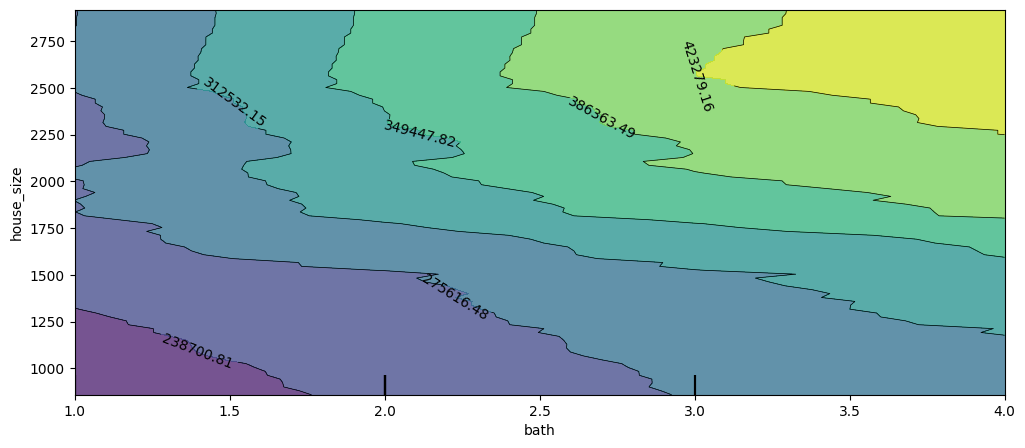

In [103]:
fig, ax = plt.subplots(figsize=(12, 5))
disp2 = PartialDependenceDisplay.from_estimator(catboost_opt, X_test_dropna_oh, [("bath", "house_size")], ax=ax)
plt.show()

In [104]:
end_time = time.time() - start_time
minutes = end_time // 60
seconds = end_time - minutes * 60
print(f"Total notebook time: {minutes} minutes and {seconds:.2f} seconds")

Total notebook time: 10.0 minutes and 15.47 seconds
